In [1]:
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import pairwise_logrank_test
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from skbio.stats.composition import clr
from sklearn.preprocessing import normalize
from sklearn.utils import resample
import time

import warnings
warnings.filterwarnings("ignore", message="FutureWarning")

import sys
# main_path = '/nfs/home/users/krakovic/sharedscratch/Histomorphological-Phenotype-Learning/'
# sys.path.append(main_path)
# from models.clustering.cox_proportional_hazard_regression_leiden_clusters import *

sys.path.append('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/libraries')
from survival import *
from clinical import load_clinical
from data_processing import *
from forest_plots import *

In [2]:
meta_folder        = 'rapids_2p5m'
matching_field     = 'samples'
event_ind_field    = 'os_event_ind'
event_data_field   = 'os_event_data'
diversity_key      = None
type_composition   = 'clr'
min_tiles          = 100
folds_pickle       = '/mnt/cephfs/home/users/krakovic/sharedscratch/Histomorphological-Phenotype-Learning/utilities/fold_creation/lattice_5x_folds_noNaN.pkl'
force_fold         = 2
h5_complete_path   = '/mnt/cephfs/home/users/krakovic/sharedscratch/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/hdf5_LATTICeA_5x_he_complete_surv_sex_filtered.h5'
h5_additional_path = '/mnt/cephfs/home/users/krakovic/sharedscratch/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/hdf5_TCGA_LUAD_5x_he_train_filtered_overall_survival.h5'
additional_as_fold = False
report_clusters    = False

max_months        = 60
use_conn          = False
use_ratio         = False
top_variance_feat = 99

l1_ratios   = [0.0]
if len(l1_ratios) == 1:
    l1_ratio = l1_ratios[0]
    
resolutions = [2.5]
if len(resolutions) == 1:
    resolution = resolutions[0]

In [3]:
# Feature selection
leiden_clusters, malignant_clusters, stromal_clusters = load_topography()

# Get clinical data
clinpath, survival, patterns_samples = load_clinical()
survival = survival.merge(patterns_samples[['samples', 'iaslc_grade']], on='samples')
survival

/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/libraries/clinical.py:7: DtypeWarning: Columns (2,10,30,37,38,52,67,84,85,110,118,134,135,136,137,138,148,149,150,217,219,221,223,224,225,226,236,242,243,244,245,248,249,250,251,252,253,254,255,256,257,261,262,263,264,265,266,267,268,269,270,271,280,282,283,285,288,289,294,295,298,299,310,311,312,313,314,315,316,317,340,374,440,441,442,443,446,447,448,449,450,451,452,453,454,455,459,460,461,462,463,464,465,466,467,468,469,481,487,508,509,510,511,512,513,514,515,538,572,638,639,640,641,644,645,646,647,648,649,650,651,652,653,657,658,659,660,661,662,663,664,665,666,667,679,685,706,707,708,709,710,711,712,713,736,770,834,835,836,839,863,887) have mixed types. Specify dtype option on import or set low_memory=False.
  clinpath = pd.read_csv('/mnt/cephfs/home/users/krakovic/sharedscratch/datasets/LATTICeA/latticea_master_clinicopathological.csv')


,index,sample_ID,Originator,Checked,Pathology Number,Case Number,male,Complete?,Receipt Delay (Days),age,...,Invasion.10,Donor Block Number.11,Core Row.11,Core Column.11,Invasion.11,Complete?.6,samples,stage_num,PDL_positive,iaslc_grade
0,11,13,ms831,crs20,PR022438N/10,2,0,Incomplete,0,76,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_0002,1,NaN,3
1,253,14,ms831,crs20,PR025028M/10,3,1,Incomplete,1,77,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_0003,1,0.0,2
2,14,18,ms831,crs20,PR026550L/10,4,0,Incomplete,1,61,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_0004,3,0.0,3
3,133,27,ms831,crs20,PR029768B/10,5,0,Incomplete,0,64,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_0005,1,0.0,1
4,34,40,crs20,ms831,PR030965Y/10,6,0,Incomplete,1,81,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_0006,2,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,1020,1054,ms831,NaN,PR051543M/15,1108,0,Incomplete,0,61,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_1108,1,0.0,3
799,1021,1055,ms831,NaN,PR051580N/15,1109,1,Incomplete,4,83,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_1109,1,0.0,3
800,1022,1056,ms831,NaN,PR051863R/15,1110,0,Incomplete,0,71,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_1110,2,1.0,3
801,1023,1057,ms831,NaN,PR052068K/15,1112,1,Incomplete,0,65,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_1112,1,0.0,3


In [4]:
# cluster_topography = pd.read_csv('/mnt/cephfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/base_dataset_work/cluster_topography_v1.csv')
# cluster_topography = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/base/consensus_frame_JLQ_DD.csv', index_col=0)
cluster_topography = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/base/consensus_frame_JLQ_DD_KR.csv', index_col=0)
cluster_topography

,cluster,malignant,feature,inflammation,necrosis,stroma_epi_ratio,stroma_cellularity,purity,description,free text
0,0,1,acinar,2.0,1.0,2.0,2.0,3.0,NaN,NaN
1,1,0,collagenosis,1.0,1.0,NaN,NaN,3.0,NaN,NaN
2,2,0,other,2.0,1.0,NaN,NaN,3.0,NaN,Anthracosis
3,3,0,collagenosis,1.0,1.0,NaN,NaN,3.0,NaN,NaN
4,4,0,cartilage,1.0,1.0,NaN,NaN,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
66,66,0,normal/near-normal lung,1.0,1.0,NaN,NaN,3.0,NaN,NaN
67,67,1,acinar,3.0,1.0,2.0,2.0,3.0,NaN,NaN
68,68,1,acinar,2.0,1.0,2.0,2.0,3.0,NaN,NaN
69,69,1,acinar,2.0,1.0,3.0,2.0,3.0,NaN,NaN


In [8]:
cluster_topography.loc[8]

cluster                                                     8
malignant                                                   0
feature                                               airways
inflammation                                              1.0
necrosis                                                  1.0
stroma_epi_ratio                                          NaN
stroma_cellularity                                        NaN
purity                                                    3.0
description                                               NaN
free text             Seromucinous glands and mediastinal fat
Name: 8, dtype: object

In [29]:
malignant_clusters = cluster_topography[cluster_topography['malignant'] == 1]['cluster'].values
stromal_clusters = cluster_topography.loc[(cluster_topography['malignant'] == 0) & (cluster_topography['feature'].isin(['collagenosis', 'elastosis', 'Lymphocytic stroma', 'other']))]['cluster'].values

all_abnormal = np.append(malignant_clusters, stromal_clusters)

In [ ]:
# malignant_clusters = stromal_clusters

In [31]:
groupby     = f'leiden_{resolution}'
# folds     = load_existing_split(folds_pickle)
# num_folds = len(folds)

main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')

In [32]:
# No detailed recurrence data for TCGA -- only look at LATTICeA
complete_df, additional_df, leiden_clusters = read_csvs_forcefold(adatas_path=adatas_path, groupby=groupby, h5_complete_path=h5_complete_path, h5_additional_path=h5_additional_path, force_fold=2)

# sample_rep_df = generate_frequency_vector(complete_df=complete_df, matching_field='samples', groupby=groupby, leiden_clusters=list(malignant_clusters), transform=False, min_perc=0.02, min_tiles=50)
# sample_rep_df

In [9]:
# additional_rep_df = generate_frequency_vector(complete_df=additional_df, matching_field='samples', groupby=groupby, leiden_clusters=malignant_clusters, transform=False, min_perc=0.02, min_tiles=50)
# additional_rep_df

In [34]:
# sample_rep_df = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/survival/00_data/LATTICeA_HPL_vector_mintile_100_all_abnormal.csv', index_col=0)
sample_rep_df = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/survival/00_data/LATTICeA_HPL_vector_mintile_100_malignant.csv', index_col=0)
# sample_rep_df = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/survival/00_data/LATTICeA_HPL_vector_mintile_100_stroma.csv', index_col=0)
sample_rep_df.columns = ['samples', 'os_event_data', 'os_event_ind'] + [int(c) for c in sample_rep_df.columns[3:]]
col_order = ['samples', 'os_event_data', 'os_event_ind'] + sorted(list(malignant_clusters))
sample_rep_df = sample_rep_df[col_order]

# additional_rep_df = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/survival/00_data/TCGA_HPL_vector_mintile_100_all_abnormal.csv', index_col=0)
additional_rep_df = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/survival/00_data/TCGA_HPL_vector_mintile_100_malignant.csv', index_col=0)
# additional_rep_df = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/survival/00_data/TCGA_HPL_vector_mintile_100_stroma.csv', index_col=0)
additional_rep_df.columns = ['samples', 'os_event_data', 'os_event_ind'] + [int(c) for c in additional_rep_df.columns[3:]]
additional_rep_df = additional_rep_df[col_order]

In [35]:
clinpath_mo = clinpath.rename(columns={'Time to Survival Status (Days)':'os_event_data',
                                        'Survival Status':'os_event_ind',
                                        'Age at Surgery':'age',
                                        'Sex':'male',
                                        'Overall Stage (8th TNM Edition)':'stage',
                                        })
clinpath_mo = clinpath_mo.replace({'Dead':1, 'Alive': 0})
clinpath_mo = clinpath_mo.replace({'IA1': 'I', 'IA2':'I', 'IA3':'I', 'IB':'I', 
                                'IIA': 'II', 'IIB':'II',
                                'IIIA':'III', 'IIIB':'III', 'IIIC':'III', 
                                'IVA':'IV'})

clinpath_mo = clinpath_mo.replace({'MALE': 1, 'FEMALE': 0})
clinpath_mo['os_event_data'] = clinpath_mo['os_event_data'] / 365 * 12


In [36]:
complete_sample_rep = sample_rep_df.merge(clinpath_mo[['samples', 'male', 'age', 'stage']], on='samples', how='left')
# complete_sample_rep = complete_sample_rep.dropna()
complete_sample_rep

,samples,os_event_data,os_event_ind,0,5,11,13,17,21,27,...,52,54,61,64,67,68,69,male,age,stage
0,ACA_0476,36.164384,0,2.943922,-1.539081,-2.538520,0.070357,-0.845934,-2.538520,-0.286318,...,-2.232228,-2.538520,0.475822,0.332721,1.135068,1.135068,1.679795,1,71,I
1,ACA_0837,60.000000,1,-3.182423,0.166491,-3.182423,0.562387,3.092720,-0.344334,-1.309415,...,-3.182423,-2.290245,2.260117,1.868639,-3.182423,-3.388857,-0.680807,0,78,III
2,ACA_0574,49.578082,0,0.628531,-2.264474,-2.264474,-1.674054,0.405388,-2.264474,-2.264474,...,-1.674054,-1.674054,1.321678,-2.264474,1.504000,-2.264474,0.271856,0,68,I
3,ACA_0329,44.087671,0,-0.886096,-2.879719,-2.590844,-1.674554,-2.879719,-2.879719,-2.185379,...,-2.590844,-2.879719,0.874891,-1.674554,0.741360,-3.283992,0.759060,0,71,I
4,ACA_0486,37.446575,0,-3.192167,-2.577810,2.669214,-0.786050,-3.270957,-2.577810,1.581073,...,0.225550,0.312562,2.278119,2.927522,-2.577810,0.789486,-0.326518,1,76,II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,ACA_0285,46.619178,1,1.197743,-0.658555,-2.961140,1.272966,0.472847,-2.961140,-2.267993,...,0.823049,-0.127927,1.683251,0.676446,2.494181,-0.476234,1.560648,0,63,I
1003,ACA_0081,57.567123,0,-2.882860,-2.882860,0.505381,-2.882860,1.392684,-0.187767,-2.882860,...,-2.133677,-2.133677,0.756695,-0.524239,-1.440530,-2.882860,0.810762,1,62,II
1004,ACA_0174,41.819178,1,2.423432,1.483424,-2.990602,1.875467,-2.428599,-2.990602,0.136351,...,-1.329986,-2.990602,0.210459,0.056308,-0.636839,0.829498,0.515840,1,77,I
1005,ACA_0263,41.326027,1,1.541884,-0.162865,-0.008714,0.242601,-1.954624,-3.086603,-0.008714,...,-3.086603,1.377580,1.656294,2.772764,2.308056,1.341213,1.180870,0,59,III


In [37]:
complete_sample_rep = complete_sample_rep.merge(patterns_samples[['samples', 'iaslc_grade']], on='samples')
non_mucinous_samples = clinpath[clinpath['2015 WHO Classification'] != 'Invasive mucinous adenocarcinoma (IMA)']['samples']
complete_sample_rep = complete_sample_rep[complete_sample_rep['samples'].isin(non_mucinous_samples)].reset_index()
complete_sample_rep['iaslc_grade'] = complete_sample_rep['iaslc_grade'].astype('category')
complete_sample_rep


,index,samples,os_event_data,os_event_ind,0,5,11,13,17,21,...,54,61,64,67,68,69,male,age,stage,iaslc_grade
0,0,ACA_0476,36.164384,0,2.943922,-1.539081,-2.538520,0.070357,-0.845934,-2.538520,...,-2.538520,0.475822,0.332721,1.135068,1.135068,1.679795,1,71,I,1
1,1,ACA_0837,60.000000,1,-3.182423,0.166491,-3.182423,0.562387,3.092720,-0.344334,...,-2.290245,2.260117,1.868639,-3.182423,-3.388857,-0.680807,0,78,III,3
2,2,ACA_0574,49.578082,0,0.628531,-2.264474,-2.264474,-1.674054,0.405388,-2.264474,...,-1.674054,1.321678,-2.264474,1.504000,-2.264474,0.271856,0,68,I,3
3,3,ACA_0329,44.087671,0,-0.886096,-2.879719,-2.590844,-1.674554,-2.879719,-2.879719,...,-2.879719,0.874891,-1.674554,0.741360,-3.283992,0.759060,0,71,I,2
4,4,ACA_0486,37.446575,0,-3.192167,-2.577810,2.669214,-0.786050,-3.270957,-2.577810,...,0.312562,2.278119,2.927522,-2.577810,0.789486,-0.326518,1,76,II,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,1002,ACA_0285,46.619178,1,1.197743,-0.658555,-2.961140,1.272966,0.472847,-2.961140,...,-0.127927,1.683251,0.676446,2.494181,-0.476234,1.560648,0,63,I,3
937,1003,ACA_0081,57.567123,0,-2.882860,-2.882860,0.505381,-2.882860,1.392684,-0.187767,...,-2.133677,0.756695,-0.524239,-1.440530,-2.882860,0.810762,1,62,II,3
938,1004,ACA_0174,41.819178,1,2.423432,1.483424,-2.990602,1.875467,-2.428599,-2.990602,...,-2.990602,0.210459,0.056308,-0.636839,0.829498,0.515840,1,77,I,3
939,1005,ACA_0263,41.326027,1,1.541884,-0.162865,-0.008714,0.242601,-1.954624,-3.086603,...,1.377580,1.656294,2.772764,2.308056,1.341213,1.180870,0,59,III,2


In [38]:
additional_grades = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/survival/00_data/tcga_luad_grades_KR_complete.csv')
TCGA_survival = pd.read_csv('/mnt/cephfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/survival/00_data/LUAD_clinical.tsv', sep='\t')

TCGA_survival = TCGA_survival[['case_submitter_id', 'age_at_diagnosis', 'gender', 'ajcc_pathologic_stage', 'primary_diagnosis']]
TCGA_survival = TCGA_survival.drop_duplicates()
TCGA_survival = TCGA_survival[TCGA_survival['age_at_diagnosis'] != "'--"]
TCGA_survival = TCGA_survival[TCGA_survival['ajcc_pathologic_stage'] != "'--"]
TCGA_survival['age'] = np.floor(TCGA_survival['age_at_diagnosis'].apply(lambda x: int(x)) / 365)
TCGA_survival['male'] = TCGA_survival['gender'].apply(lambda x: 1 if x == 'male' else 0)

TCGA_survival = TCGA_survival.replace({'Stage IA': 'I', 'Stage IB':'I', 'Stage I':'I', 
                             'Stage IIA': 'II', 'Stage IIB':'II', 'Stage II':'II',
                             'Stage IIIA':'III', 'Stage IIIB':'III', 'Stage IIIC':'III', 
                             'Stage IV':'IV'})

TCGA_survival['stage_num'] = TCGA_survival['ajcc_pathologic_stage'].map({'I':1, 'II':2, 'III':3, 'IV':4})
TCGA_survival['stage_num'] = pd.Categorical(TCGA_survival['stage_num'], categories=[1, 2, 3, 4], ordered=True)
TCGA_survival['stage'] = pd.Categorical(TCGA_survival['ajcc_pathologic_stage'], categories=['I', 'II', 'III', 'IV'], ordered=True)
TCGA_survival.rename(columns={'case_submitter_id':'samples'}, inplace=True)
TCGA_survival = TCGA_survival.merge(additional_grades[['samples', 'iaslc_grade']], on='samples')
TCGA_survival['iaslc_grade'] = pd.Categorical(TCGA_survival['iaslc_grade'], categories=['G1', 'G2', 'G3'], ordered=True)
TCGA_survival['stage_num'] = TCGA_survival['ajcc_pathologic_stage'].map({'I':1, 'II':2, 'III':3, 'IV':4})
TCGA_survival.rename(columns={'iaslc_grade':'iaslc_grade_'}, inplace=True)
TCGA_survival['iaslc_grade'] = TCGA_survival['iaslc_grade_'].map({'G1':1, 'G2':2, 'G3':3})

TCGA_survival = TCGA_survival.dropna(subset=['iaslc_grade'])

conventional_adenocarcinoma = ['Adenocarcinoma, NOS', 'Adenocarcinoma with mixed subtypes', 'Papillary adenocarcinoma, NOS', 'Micropapillary carcinoma, NOS', 
                               'Bronchiolo-alveolar carcinoma, non-mucinous', 'Solid carcinoma, NOS', 'Bronchiolo-alveolar adenocarcinoma, NOS']
non_mucinous_tcga = TCGA_survival[TCGA_survival['primary_diagnosis'].isin(conventional_adenocarcinoma)]['samples'].values

In [39]:
# additional_sample_rep = additional_rep_df.merge(additional_df[['samples', 'os_event_data', 'os_event_ind']].drop_duplicates(), on='samples', how='left')
additional_sample_rep = additional_rep_df.copy(deep=True)
additional_sample_rep = additional_sample_rep[additional_rep_df['samples'].isin(non_mucinous_tcga)]
additional_sample_rep['os_event_data'] = additional_sample_rep['os_event_data'].apply(lambda x: x if x < 60 else 60)

additional_sample_rep

,samples,os_event_data,os_event_ind,0,5,11,13,17,21,27,...,47,48,50,52,54,61,64,67,68,69
0,TCGA-55-7574,32.712329,1,-2.209698,-2.209698,0.771360,4.103565,2.157654,3.990236,4.460240,...,0.771360,-2.209698,2.157654,-2.209698,-2.209698,2.968585,3.604573,-2.209698,1.464507,-2.209698
1,TCGA-55-8512,19.956164,1,2.093012,-1.634409,-1.634409,1.399864,-1.634409,-1.634409,0.706717,...,-1.634409,-1.634409,1.399864,-1.634409,5.566530,-1.634409,-1.634409,2.316155,-1.634409,-1.634409
2,TCGA-78-7148,20.580822,1,-1.023123,0.229640,0.848679,-1.716270,-3.195214,-3.195214,-0.617658,...,-3.195214,1.056319,-0.617658,2.234974,-0.329976,0.229640,1.228169,1.116943,1.056319,1.541827
4,TCGA-NJ-A55R,19.824658,0,0.931240,-2.300483,-2.300483,1.490855,4.776054,1.624387,0.238092,...,-2.300483,-2.300483,2.378159,-2.300483,-2.300483,3.416146,2.877150,-2.300483,-2.300483,2.912241
5,TCGA-49-4488,28.569863,1,1.309008,2.015578,-1.896445,-0.104685,-0.692472,-2.939412,-2.939412,...,0.896763,0.876144,1.399392,-1.203298,1.775627,-0.797833,0.182997,2.738284,1.910218,1.960770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,TCGA-44-6779,16.438356,1,-0.608513,-0.608513,-0.608513,7.549438,-0.608513,2.745417,-0.608513,...,-0.608513,-0.608513,4.131711,-0.608513,2.745417,2.745417,4.131711,-0.608513,-0.608513,-0.608513
397,TCGA-78-7542,10.553425,1,-2.608607,0.295209,-2.608607,3.098570,-2.608607,-2.608607,0.700674,...,3.157410,-0.397938,2.374651,-2.608607,-2.608607,2.167012,0.988357,-2.608607,0.295209,0.295209
398,TCGA-95-8494,2.761644,0,-2.278019,-2.278019,-2.278019,1.119056,0.782584,2.006359,1.571041,...,3.627493,0.559440,3.639054,-0.133707,-2.278019,0.271758,1.252588,-2.278019,-2.278019,-0.133707
399,TCGA-86-8585,11.605479,0,-2.592468,-1.469058,-2.592468,3.630808,1.475381,-0.775911,1.015849,...,2.925391,3.258330,2.949783,-2.592468,-1.469058,3.284532,2.861675,-1.469058,-1.469058,0.140380


In [40]:
additional_sample_rep = additional_sample_rep.merge(TCGA_survival[['samples', 'iaslc_grade']], on='samples', how='left').reset_index()
additional_sample_rep['iaslc_grade'] = additional_sample_rep['iaslc_grade'].astype('category')
additional_sample_rep

,index,samples,os_event_data,os_event_ind,0,5,11,13,17,21,...,48,50,52,54,61,64,67,68,69,iaslc_grade
0,0,TCGA-55-7574,32.712329,1,-2.209698,-2.209698,0.771360,4.103565,2.157654,3.990236,...,-2.209698,2.157654,-2.209698,-2.209698,2.968585,3.604573,-2.209698,1.464507,-2.209698,3
1,1,TCGA-55-8512,19.956164,1,2.093012,-1.634409,-1.634409,1.399864,-1.634409,-1.634409,...,-1.634409,1.399864,-1.634409,5.566530,-1.634409,-1.634409,2.316155,-1.634409,-1.634409,1
2,2,TCGA-78-7148,20.580822,1,-1.023123,0.229640,0.848679,-1.716270,-3.195214,-3.195214,...,1.056319,-0.617658,2.234974,-0.329976,0.229640,1.228169,1.116943,1.056319,1.541827,2
3,3,TCGA-NJ-A55R,19.824658,0,0.931240,-2.300483,-2.300483,1.490855,4.776054,1.624387,...,-2.300483,2.378159,-2.300483,-2.300483,3.416146,2.877150,-2.300483,-2.300483,2.912241,2
4,4,TCGA-49-4488,28.569863,1,1.309008,2.015578,-1.896445,-0.104685,-0.692472,-2.939412,...,0.876144,1.399392,-1.203298,1.775627,-0.797833,0.182997,2.738284,1.910218,1.960770,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,334,TCGA-44-6779,16.438356,1,-0.608513,-0.608513,-0.608513,7.549438,-0.608513,2.745417,...,-0.608513,4.131711,-0.608513,2.745417,2.745417,4.131711,-0.608513,-0.608513,-0.608513,3
335,335,TCGA-78-7542,10.553425,1,-2.608607,0.295209,-2.608607,3.098570,-2.608607,-2.608607,...,-0.397938,2.374651,-2.608607,-2.608607,2.167012,0.988357,-2.608607,0.295209,0.295209,3
336,336,TCGA-95-8494,2.761644,0,-2.278019,-2.278019,-2.278019,1.119056,0.782584,2.006359,...,0.559440,3.639054,-0.133707,-2.278019,0.271758,1.252588,-2.278019,-2.278019,-0.133707,3
337,337,TCGA-86-8585,11.605479,0,-2.592468,-1.469058,-2.592468,3.630808,1.475381,-0.775911,...,3.258330,2.949783,-2.592468,-1.469058,3.284532,2.861675,-1.469058,-1.469058,0.140380,3


In [41]:
from sklearn.model_selection import KFold

data_dict = dict()

kf = KFold(n_splits=5, shuffle=True, random_state=0)

for fold, (train_idx, test_idx) in enumerate(kf.split(complete_sample_rep)):
    data_dict[fold] = dict()
    data_dict[fold]['train_X'] = complete_sample_rep.loc[train_idx][malignant_clusters]
    data_dict[fold]['train_all'] = complete_sample_rep.loc[train_idx]
    data_dict[fold]['test_X'] = complete_sample_rep.loc[test_idx][malignant_clusters]
    data_dict[fold]['test_all'] = complete_sample_rep.loc[test_idx] 
    data_dict[fold]['additional_X'] = additional_sample_rep.loc[:, malignant_clusters]
    data_dict[fold]['additional_all'] = additional_sample_rep

In [ ]:
# # Original folds -- performance is no different
# data_dict = dict()

# kf = KFold(n_splits=5, shuffle=True, random_state=0)

# for fold, fold_patients in enumerate(folds):
#     train_patients = fold_patients[0] + fold_patients[1]
#     test_patients = fold_patients[2]
#     data_dict[fold] = dict()
#     data_dict[fold]['train_X'] = complete_sample_rep.loc[complete_sample_rep['samples'].isin(train_patients)][malignant_clusters]
#     data_dict[fold]['train_all'] = complete_sample_rep.loc[complete_sample_rep['samples'].isin(train_patients)]
#     data_dict[fold]['test_X'] = complete_sample_rep.loc[complete_sample_rep['samples'].isin(test_patients)][malignant_clusters]
#     data_dict[fold]['test_all'] = complete_sample_rep.loc[complete_sample_rep['samples'].isin(test_patients)]
#     data_dict[fold]['additional_X'] = additional_sample_rep.loc[:, malignant_clusters]
#     data_dict[fold]['additional_all'] = additional_sample_rep

In [42]:
def train_cox(data_dict, fold,  penalizer, l1_ratio, event_data_col, event_ind_col, cols_to_include, additional_flag=True, robust=True, save_path=None):
    train, test = data_dict[fold]['train_all'], data_dict[fold]['test_all']
    if additional_flag:
        additional = data_dict[fold]['additional_all']

    cols_to_include_ = cols_to_include + [event_data_col, event_ind_col]

    cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)

    try:
        cph.fit(train[cols_to_include_], event_data_col, event_ind_col, show_progress=False)
    except ValueError:
        train = train[~train[cols_to_include_].isna()]
        cph.fit(train, event_data_col, event_ind_col, show_progress=False, robust=robust)

    summary = cph.summary
    summary = summary.sort_values(by='coef', ascending=True)

    predictions = dict()
    predictions['train'] = cph.predict_partial_hazard(train)
    predictions['test'] = cph.predict_partial_hazard(test)
    predictions['additional'] = cph.predict_partial_hazard(additional)

    train_ci = concordance_index(train[event_data_col], -cph.predict_partial_hazard(train), train[event_ind_col])
    test_ci = concordance_index(test[event_data_col], -cph.predict_partial_hazard(test), test[event_ind_col])
    if additional_flag:
        additional_ci = concordance_index(additional[event_data_col], -cph.predict_partial_hazard(additional), additional[event_ind_col])
    else:
        additional_ci = 0

    if save_path is not None:
        summary.to_csv(os.path.join(save_path, f'{event_ind_col}_fold_{fold}.csv'))
    print(f'Fold {fold} Alpha {penalizer:.3f}\tC-index (Train/test/additional): {train_ci:.2f}/{test_ci:.2f}/{additional_ci:.2f}')

    return summary, [train_ci, test_ci, additional_ci], predictions, cph

In [43]:
# from survival_v2 import train_cox

event_data_field = 'os_event_data'
event_ind_field = 'os_event_ind'

warnings.filterwarnings("ignore")
alphas    = 10.0 ** np.linspace(-4, 4, 50)
l1_ratios = [0]
# l1_ratios = [0.2]
num_folds = 5
# cols_to_include = list(malignant_clusters)
# cols_to_include = ['iaslc_grade'] 
cols_to_include = list(malignant_clusters) + ['iaslc_grade'] 
# cols_to_include = data_res_folds_clinical[0]['features'] + ['age', 'male', 'stage_num', 'iaslc_grade']

for l1_ratio in l1_ratios:
	print('L1 Penalty', l1_ratio)
	cox_data = list()
	alpha_path = os.path.join(main_cluster_path, f'{meta_folder}_{groupby}_l1ratio_{str(l1_ratio).replace(".", "p")}_mintiles_{str(min_tiles)}_{event_ind_field}_{str(generate_timestamp())}')
	if not os.path.exists(alpha_path): 
		os.makedirs(alpha_path)
	groupby     = 'leiden_%s' % resolution
	alphas_df   = list()
	for alpha in alphas:
		print('\n\t\t', 'Alpha', alpha)

		summaries = list()
		c_indexes = list()

		for fold in range(num_folds):
			summary, ci, _, _ = train_cox(data_dict=data_dict, fold=fold, penalizer=alpha, l1_ratio=l1_ratio, event_ind_col=event_ind_field, event_data_col=event_data_field, cols_to_include=cols_to_include, additional_flag=True, save_path=None)
			summaries.append(summary)
			c_indexes.append(ci)

		cis_df = pd.DataFrame(c_indexes, columns=['train', 'test', 'additional'])
		cis_df['alpha'] = alpha
		cis_df = cis_df.reset_index()
		cis_df.rename(columns={'index':'fold'}, inplace=True)
		alphas_df.append(cis_df)

	all_cis_df = pd.concat(alphas_df)
	all_cis_df.to_csv(os.path.join(alpha_path, 'c_indexes.csv'))

L1 Penalty 0

		 Alpha 0.0001
Fold 0 Alpha 0.000	C-index (Train/test/additional): 0.67/0.64/0.60
Fold 1 Alpha 0.000	C-index (Train/test/additional): 0.67/0.65/0.61
Fold 2 Alpha 0.000	C-index (Train/test/additional): 0.65/0.72/0.60
Fold 3 Alpha 0.000	C-index (Train/test/additional): 0.68/0.60/0.61
Fold 4 Alpha 0.000	C-index (Train/test/additional): 0.67/0.62/0.59

		 Alpha 0.00014563484775012445
Fold 0 Alpha 0.000	C-index (Train/test/additional): 0.67/0.64/0.60
Fold 1 Alpha 0.000	C-index (Train/test/additional): 0.67/0.65/0.61
Fold 2 Alpha 0.000	C-index (Train/test/additional): 0.65/0.72/0.60
Fold 3 Alpha 0.000	C-index (Train/test/additional): 0.68/0.60/0.61
Fold 4 Alpha 0.000	C-index (Train/test/additional): 0.67/0.62/0.59

		 Alpha 0.00021209508879201905
Fold 0 Alpha 0.000	C-index (Train/test/additional): 0.67/0.64/0.60
Fold 1 Alpha 0.000	C-index (Train/test/additional): 0.67/0.65/0.61
Fold 2 Alpha 0.000	C-index (Train/test/additional): 0.65/0.72/0.60
Fold 3 Alpha 0.000	C-index (Train

In [26]:
def get_best_alpha(alpha_path):
    try:
        results_path = os.path.join(alpha_path, 'c_indexes.csv')
        results = pd.read_csv(results_path)
    except:
        results = alpha_path

    alphas = np.unique(results['alpha'].values)
    mean_cis = list()

    for alpha in alphas:
        subset = results[results['alpha'] == alpha]
        train = subset['train'].mean()
        test = subset['test'].mean()
        additional = subset['additional'].mean()
        if additional > 0:
            # mean_cis.append((train, test, additional))
            mean_cis.append(np.mean((train, test, additional)))
        else:
            mean_cis.append((train, test))

    max_ci = max(mean_cis)
    alpha_index = mean_cis.index(max_ci)

    best_alpha = alphas[alpha_index]
    
    return best_alpha
    
best_alpha = get_best_alpha(alpha_path=alpha_path)
# best_alpha = 0.019306977288832496
# best_alpha = 0.18420699693267145
# best_alpha = 3.727593720314938

best_alpha

0.3906939937054613

In [44]:
def get_high_low_risks(data_dict, predictions, fold, alpha_path, additional_flag=True, q_buckets=2):
    fold_data_all = dict()
    fold_data_all['train'] = data_dict[fold]['train_all']
    fold_data_all['test'] = data_dict[fold]['test_all']
    if additional_flag:
        fold_data_all['additional'] = data_dict[fold]['additional_all']
        sets = ['train', 'test', 'additional']
    else:
        sets = ['train', 'test']

    high_low = list()

    for set_name in sets:
        current_predictions = predictions[set_name].copy(deep=True)
        current_data = fold_data_all[set_name].copy(deep=True)
        current_data['hazard'] = current_predictions

        if set_name == 'train':
            if q_buckets == 2:
                hazard_cutoff = np.median(current_predictions)
            else:
                cutoffs = create_risk_buckets(predictions=predictions, num_groups=q_buckets)
        
        if q_buckets == 2:
            current_data[f'h_bin_{fold}'] = (current_data['hazard'] > hazard_cutoff) * 1
        else:
            current_data[f'h_bin_{fold}'] = pd.cut(current_data['hazard'], bins=[-np.inf] + list(cutoffs) + [np.inf],
                                                   labels=[i for i in range(len(list(cutoffs))+1)])

        current_data['original_set'] = set_name
        high_low.append(current_data)
    
    high_low_frame = pd.concat(high_low)
    high_low_frame['fold'] = fold
    high_low_frame.to_csv(os.path.join(alpha_path, f'high_low_fold_{fold}.csv'))
    
    return high_low_frame

In [45]:
warnings.filterwarnings("ignore")

l1_ratio = 0
# l1_ratio = 0.2

risk_groups = [pd.DataFrame(), pd.DataFrame()]
additional_risk = pd.DataFrame()
cis_folds = list()
estimators = list()

summaries = list()
c_indexes = list()
cph_models = list()

for fold in range(num_folds):
    summary, ci, predictions, cph_model = train_cox(data_dict=data_dict, fold=fold, penalizer=best_alpha, l1_ratio=l1_ratio, event_ind_col=event_ind_field, event_data_col=event_data_field, cols_to_include=cols_to_include, additional_flag=True, save_path=alpha_path)
    summary.index = [f'HPC {c}' for c in summary.index.values]
    summary.index.name = 'covariate'
    high_low_frame = get_high_low_risks(data_dict=data_dict, predictions=predictions, fold=fold, alpha_path=alpha_path, q_buckets=2)
    forest_plots(frame=summary, scale_to_plot='exp', fold=fold, event_ind_col=event_ind_field, save_path=alpha_path)
    summaries.append(summary)
    c_indexes.append(ci)
    cph_models.append(cph_model)

    # print('\t\tFold', fold, 'Alpha', np.round(best_alpha,2), 'Train/Test/Additional C-Index:', '/'.join([str(i) for i in c_indexes[fold]]))
    

Fold 0 Alpha 0.391	C-index (Train/test/additional): 0.66/0.65/0.62
Fold 1 Alpha 0.391	C-index (Train/test/additional): 0.66/0.64/0.62
Fold 2 Alpha 0.391	C-index (Train/test/additional): 0.64/0.71/0.62
Fold 3 Alpha 0.391	C-index (Train/test/additional): 0.67/0.60/0.62
Fold 4 Alpha 0.391	C-index (Train/test/additional): 0.66/0.64/0.62


### High-low risk

In [82]:
# High-Low risk groups and KMs

# alpha_path = '/mnt/cephfs/sharedscratch/users/krakovic/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/rapids_2p5m/rapids_2p5m_leiden_2.5_l1ratio_0p2_mintiles_100_os_event_ind_20241126_155025_all_abnormal_HPL_vectors/'

high_low = list()

for fold in range(num_folds):
    high_low_frame = pd.read_csv(os.path.join(alpha_path, f"high_low_fold_{fold}.csv"))
    high_low.append(high_low_frame)

p = 0.003
p = 0.018
p < 0.001
p = 0.365
p = 0.003


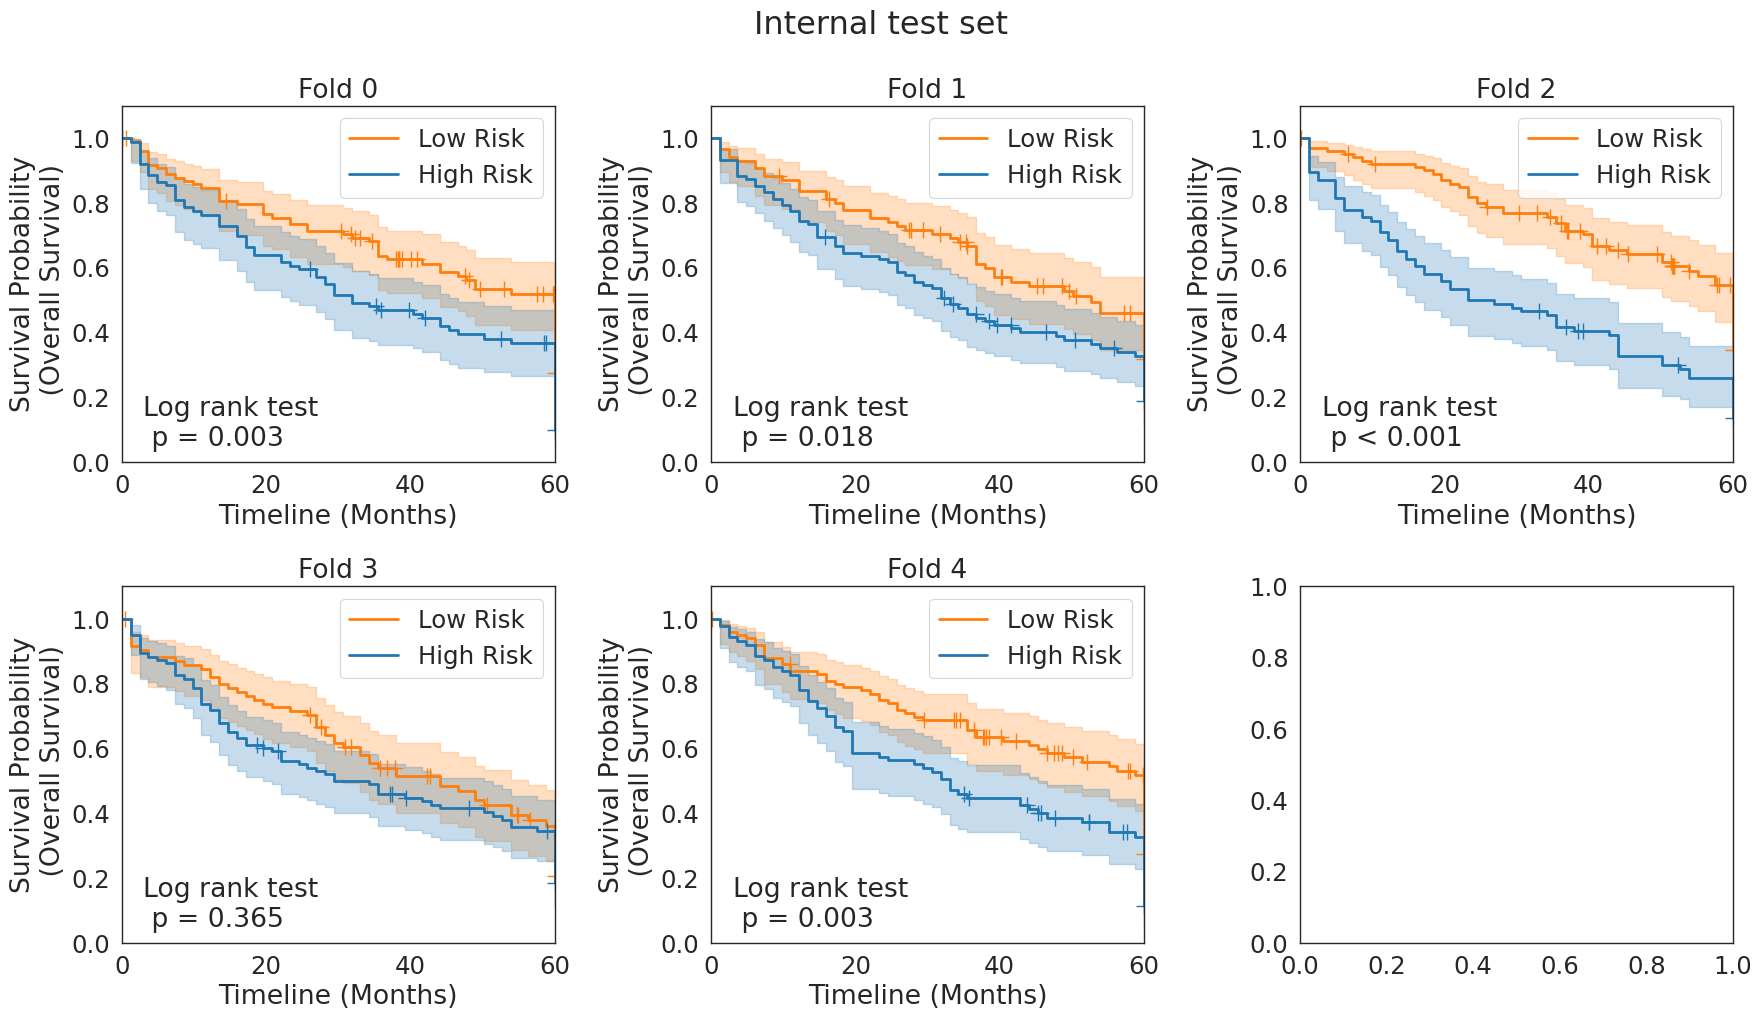

In [83]:
sns.set_theme(style='white')
sns.set_context(context='paper', font_scale=2.0)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,10.5))
axs = axs.flatten()

for i in range(num_folds):
    risk_groups = high_low[i]
    risk_groups = risk_groups[risk_groups['original_set'] == 'test']
    plot_km_two_groups(risk_groups, event_ind_field, event_data_field, f'h_bin_{i}', 60, add_counts=False, title=f'Fold {i}', ax=axs[i])
# plot_km_two_groups(additional_risk_groups, event_ind_field, event_data_field, 'risk', 60, title='External test set', ax=ax2)

plt.suptitle('Internal test set')
plt.tight_layout()
plt.show()

p = 0.001
p = 0.004
p < 0.001
p < 0.001
p = 0.008


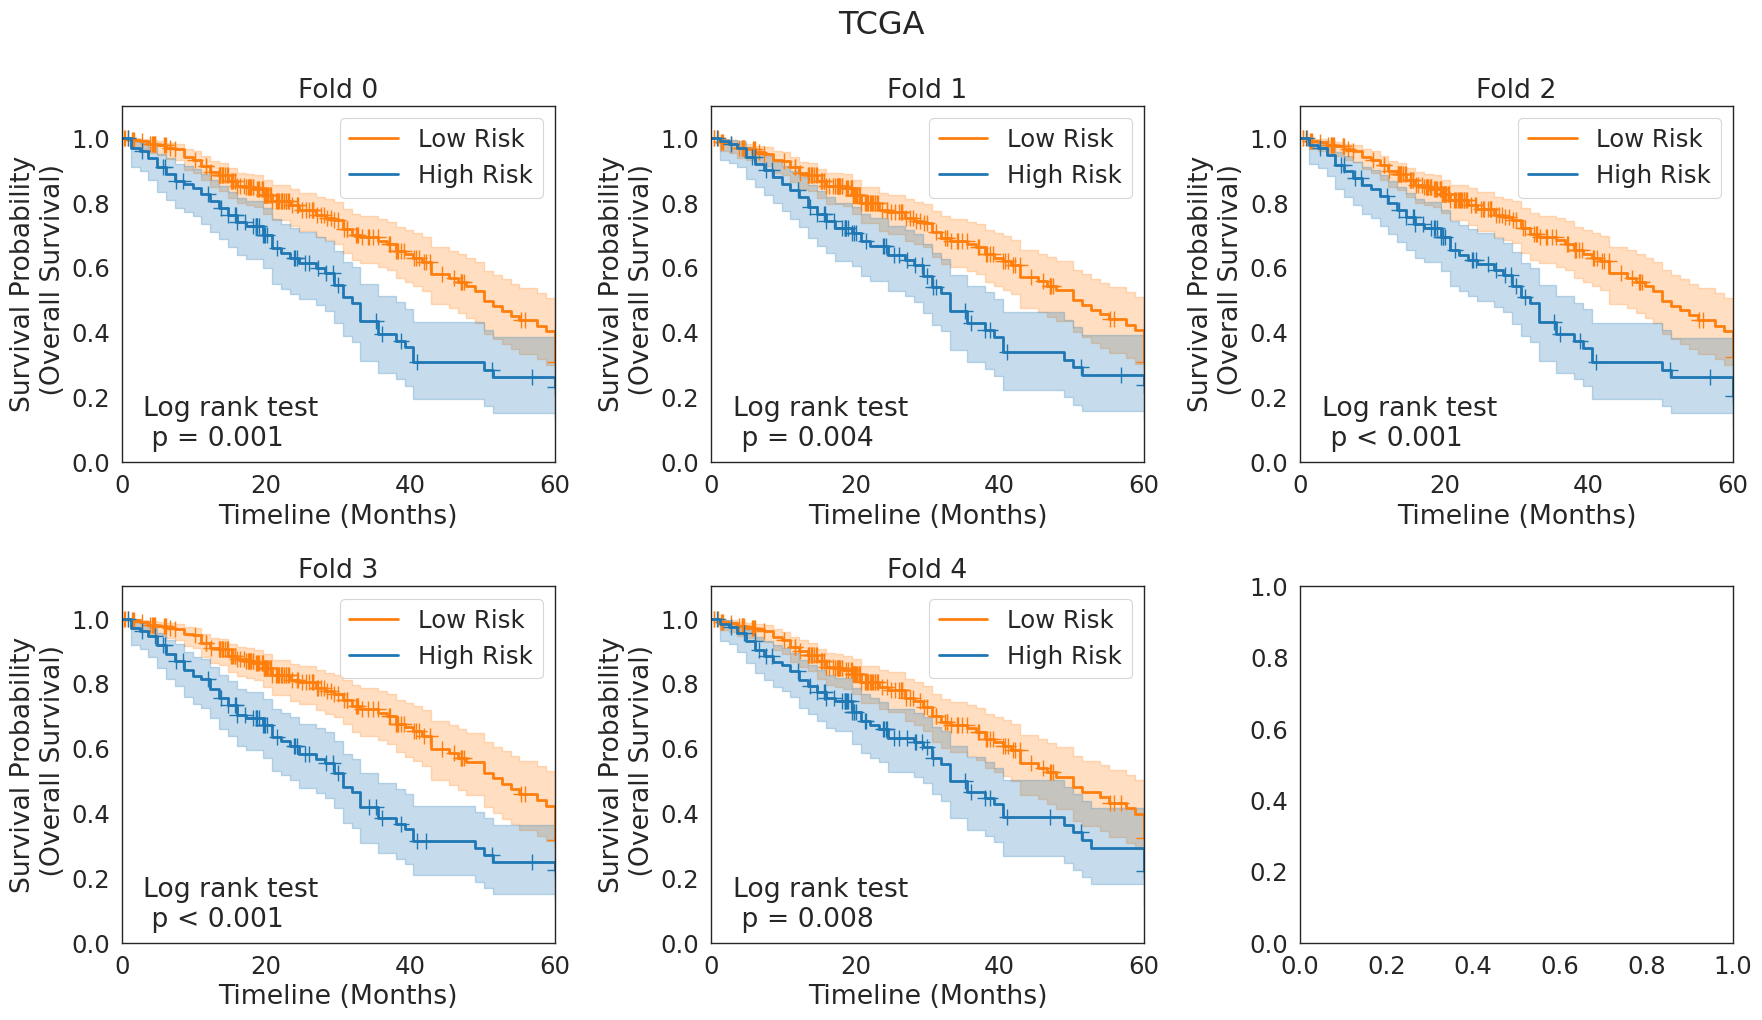

In [84]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,10.5))
axs = axs.flatten()

for i in range(num_folds):
    risk_groups = high_low[i]
    risk_groups = risk_groups[risk_groups['original_set'] == 'additional']
    plot_km_two_groups(risk_groups, event_ind_field, event_data_field, f'h_bin_{i}', 60, add_counts=False, title=f'Fold {i}', ax=axs[i])
# plot_km_two_groups(additional_risk_groups, event_ind_field, event_data_field, 'risk', 60, title='External test set', ax=ax2)

plt.suptitle('TCGA')
plt.tight_layout()
plt.show()

### SHAP Values

In [85]:
import shap

fold = 0

train, test, additional = data_dict[fold]['train_X'], data_dict[fold]['test_X'], data_dict[fold]['additional_X']
explainer = shap.explainers.Permutation(cph_models[fold].predict_partial_hazard, train)
train_explanation = explainer(train)

PermutationExplainer explainer: 753it [00:34, 15.46it/s]                                                                                                                                                                                                                                                                                                                               


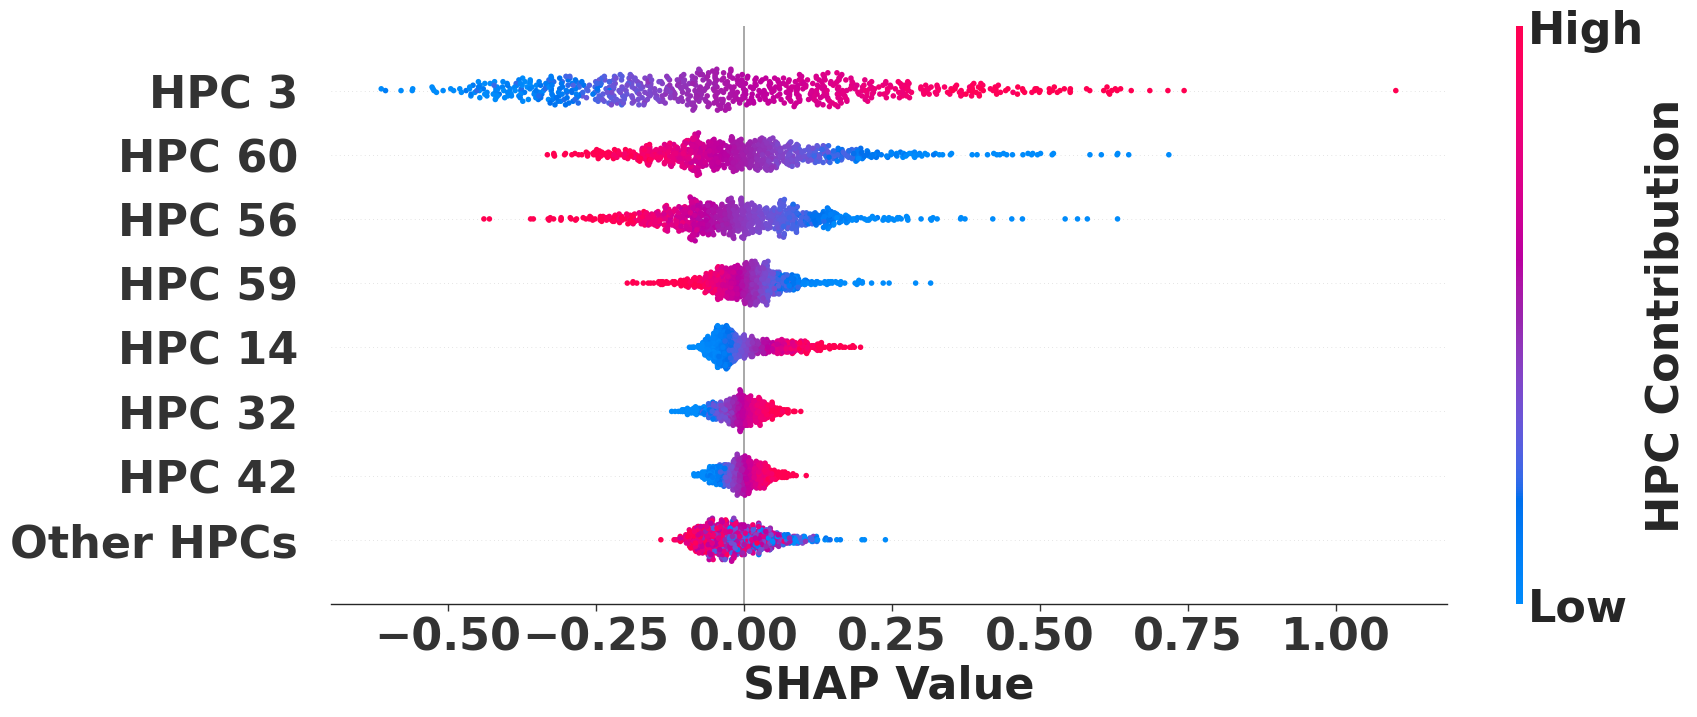

In [95]:
fontsize = 32
shap.plots.beeswarm(train_explanation, max_display=8, show=False, plot_size=(18,7.5))

figure = plt.gcf()
figure.axes[0].set_xlabel('SHAP Value', fontsize=fontsize, fontdict={'fontweight':'bold'})
figure.axes[1].set_ylabel('HPC Contribution', fontsize=fontsize, fontdict={'fontweight':'bold'})

for ax in [figure.axes[0], figure.axes[1]]:
		for tick in ax.xaxis.get_major_ticks():
			tick.label1.set_fontweight('bold')
			tick.label2.set_fontweight('bold')
			tick.label1.set_fontsize(fontsize)
			tick.label2.set_fontsize(fontsize)
		for tick in ax.yaxis.get_major_ticks():
			tick.label1.set_fontweight('bold')
			tick.label2.set_fontweight('bold')
			tick.label1.set_fontsize(fontsize)
			tick.label2.set_fontsize(fontsize)

# For all abnormal
# figure.axes[0].set_yticklabels(labels=['HPC 27', 'HPC 0', 'HPC 30', 'HPC 13', 'HPC 56', 'HPC 1', 'HPC 59', 'HPC 48', 'HPC 64', 'HPC 41', 'HPC 69', 'HPC 21', 'HPC 2', 'Other HPCs'][::-1])

# For malignant
# figure.axes[0].set_yticklabels(labels=['HPC 27', 'HPC 69', 'HPC 0', 'HPC 30', 'HPC 41', 'HPC 13', 'HPC 48', 'HPC 64', 'HPC 21', 'HPC 33', 'HPC 5', 'HPC 44', 'HPC 40', 'Other HPCs'][::-1])

# For stroma
figure.axes[0].set_yticklabels(labels=['HPC 3', 'HPC 60', 'HPC 56', 'HPC 59', 'HPC 14', 'HPC 32', 'HPC 42', 'Other HPCs'][::-1])

plt.show()

In [96]:
explainer = shap.explainers.Permutation(cph_models[fold].predict_partial_hazard, test)
test_explanation = explainer(test)

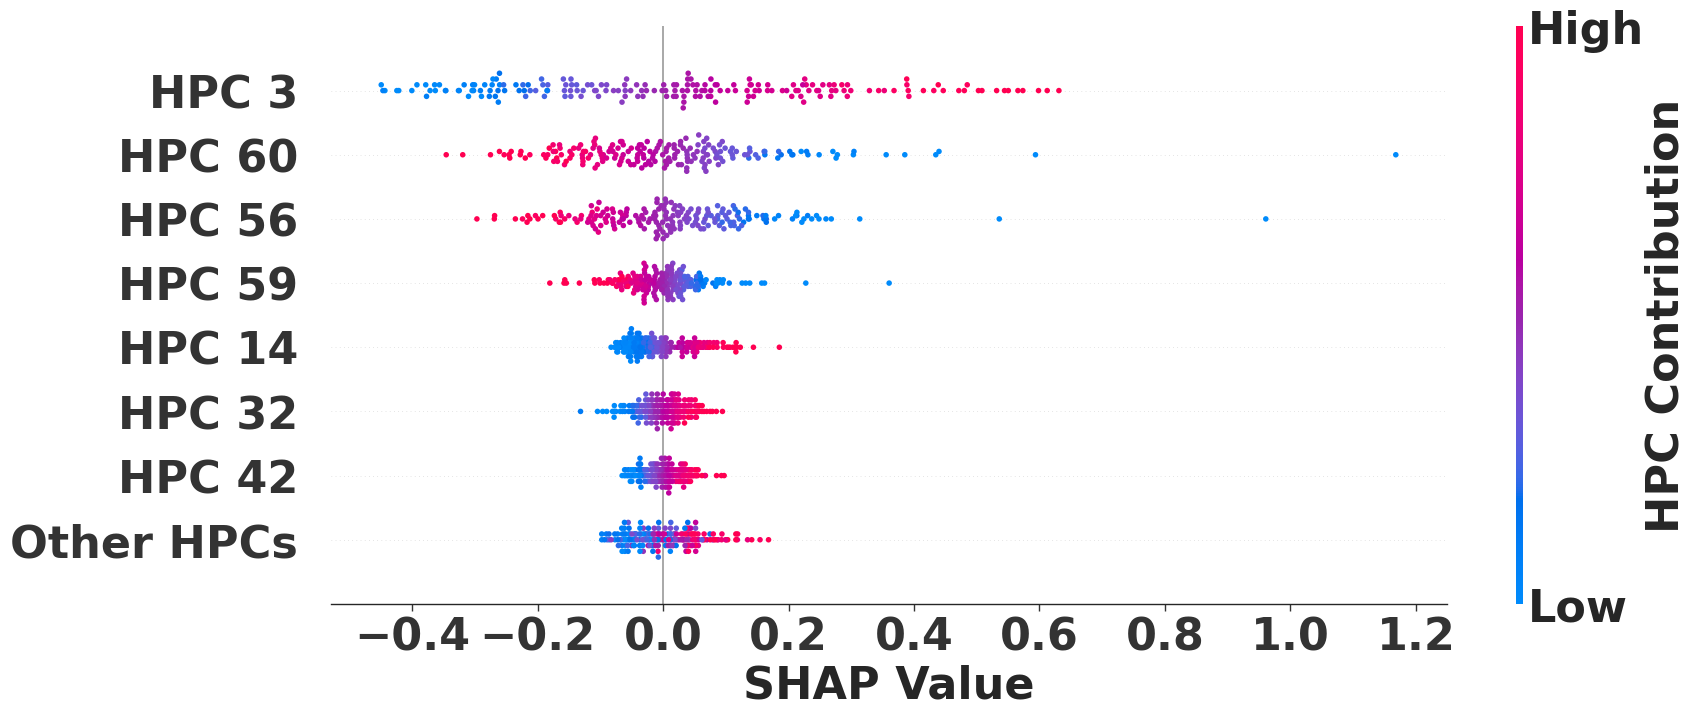

In [99]:
fontsize = 32
shap.plots.beeswarm(test_explanation, max_display=8, show=False, plot_size=(18,7.5))

figure = plt.gcf()
figure.axes[0].set_xlabel('SHAP Value', fontsize=fontsize, fontdict={'fontweight':'bold'})
figure.axes[1].set_ylabel('HPC Contribution', fontsize=fontsize, fontdict={'fontweight':'bold'})

for ax in [figure.axes[0], figure.axes[1]]:
		for tick in ax.xaxis.get_major_ticks():
			tick.label1.set_fontweight('bold')
			tick.label2.set_fontweight('bold')
			tick.label1.set_fontsize(fontsize)
			tick.label2.set_fontsize(fontsize)
		for tick in ax.yaxis.get_major_ticks():
			tick.label1.set_fontweight('bold')
			tick.label2.set_fontweight('bold')
			tick.label1.set_fontsize(fontsize)
			tick.label2.set_fontsize(fontsize)

# All abnormal
# figure.axes[0].set_yticklabels(labels=['HPC 27', 'HPC 0', 'HPC 30', 'HPC 13', 'HPC 56', 'HPC 1', 'HPC 64', 'HPC 59', 'HPC 48', 'HPC 41', 'HPC 69', 'HPC 2', 'HPC 21', 'Other HPCs'][::-1])

# Malignant
# figure.axes[0].set_yticklabels(labels=['HPC 27', 'HPC 0', 'HPC 69', 'HPC 30', 'HPC 13', 'HPC 41', 'HPC 48', 'HPC 64', 'HPC 33', 'HPC 21', 'HPC 5', 'HPC 40', 'HPC 44', 'Other HPCs'][::-1])

# For stroma
figure.axes[0].set_yticklabels(labels=['HPC 3', 'HPC 60', 'HPC 56', 'HPC 59', 'HPC 14', 'HPC 32', 'HPC 42', 'Other HPCs'][::-1])


plt.show()


In [100]:
# additional_explanation = explainer(additional)

explainer = shap.explainers.Permutation(cph_models[fold].predict_partial_hazard, additional)
additional_explanation = explainer(additional)

PermutationExplainer explainer: 340it [00:15,  7.62it/s]                                                                                                                                                                                                                                                                                                                               


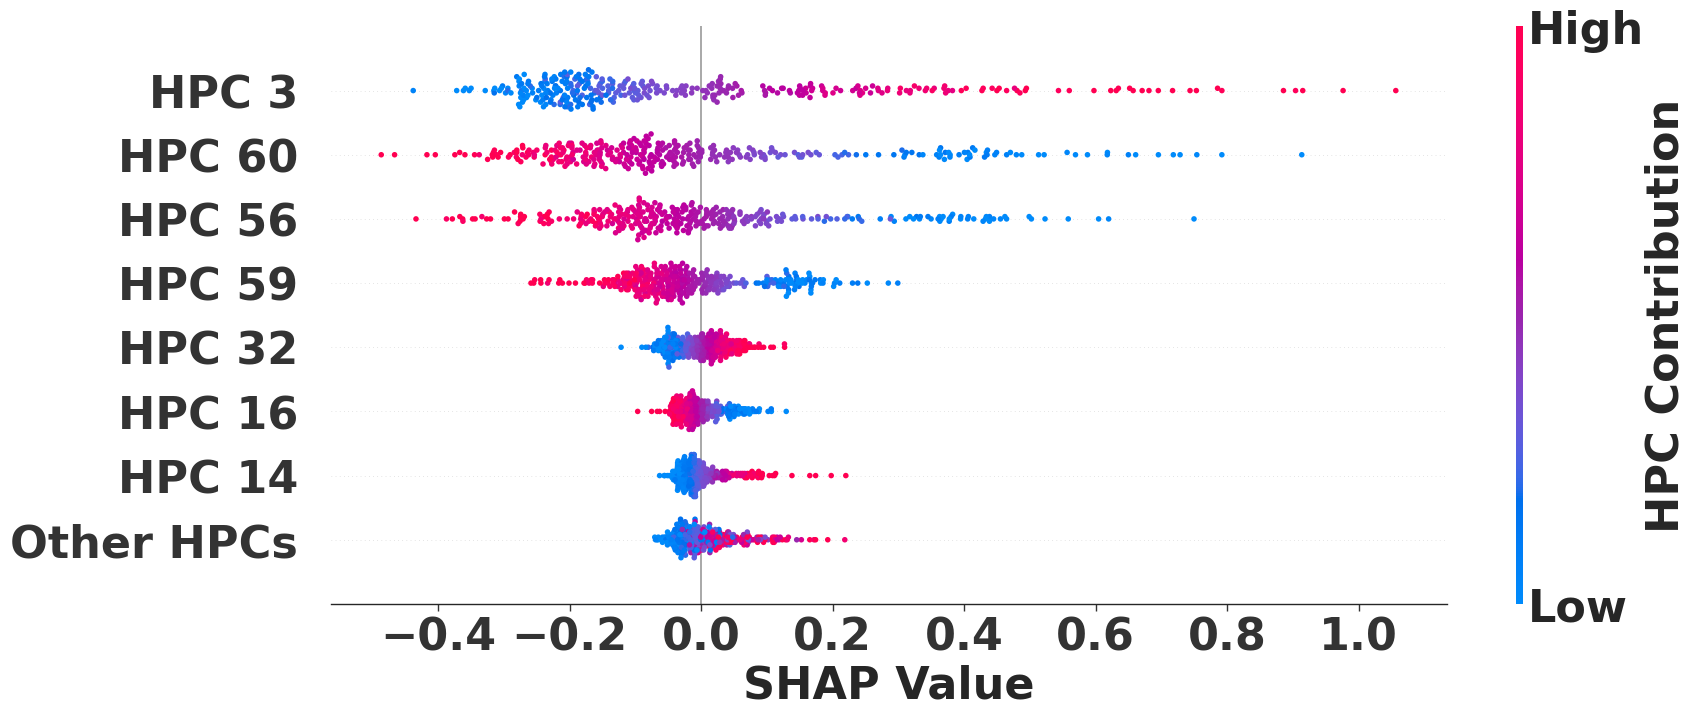

In [104]:
fontsize = 32
shap.plots.beeswarm(additional_explanation, max_display=8, show=False, plot_size=(18,7.5))

figure = plt.gcf()
figure.axes[0].set_xlabel('SHAP Value', fontsize=fontsize, fontdict={'fontweight':'bold'})
figure.axes[1].set_ylabel('HPC Contribution', fontsize=fontsize, fontdict={'fontweight':'bold'})

for ax in [figure.axes[0], figure.axes[1]]:
		for tick in ax.xaxis.get_major_ticks():
			tick.label1.set_fontweight('bold')
			tick.label2.set_fontweight('bold')
			tick.label1.set_fontsize(fontsize)
			tick.label2.set_fontsize(fontsize)
		for tick in ax.yaxis.get_major_ticks():
			tick.label1.set_fontweight('bold')
			tick.label2.set_fontweight('bold')
			tick.label1.set_fontsize(fontsize)
			tick.label2.set_fontsize(fontsize)

# All abnormal
# figure.axes[0].set_yticklabels(labels=['HPC 27', 'HPC 30', 'HPC 59', 'HPC 13', 'HPC 56', 'HPC 0', 'HPC 69', 'HPC 64', 'HPC 1', 'HPC 48', 'HPC 41', 'HPC 60', 'HPC 33', 'Other HPCs'][::-1])

# Malignant
# figure.axes[0].set_yticklabels(labels=['HPC 27', 'HPC 69', 'HPC 30', 'HPC 0', 'HPC 13', 'HPC 41', 'HPC 48', 'HPC 64', 'HPC 33', 'HPC 21', 'HPC 5', 'HPC 40', 'HPC 44', 'Other HPCs'][::-1])

# For stroma
figure.axes[0].set_yticklabels(labels=['HPC 3', 'HPC 60', 'HPC 56', 'HPC 59', 'HPC 32', 'HPC 16', 'HPC 14', 'Other HPCs'][::-1])

plt.show()
